# NFL RECEIVING YARDAGE PREDICTOR

Big data is becoming a big part of our world and sports are no execption. Teams are increasingly using advanced analytics to find an edge over their competition.

On such example of this is using modeling to find out what metrics are most predictive of future success. For example, what are the elements of wide receiver play in the NFL that are most important? 

**Problem to be solved:** Do past receiving yards do a good job of predicting future receiving yards or are there other metrics that can do a better job?

**Key Metrics**

*   Receiving yards -- how many yards a player gains 
*   Targets -- how often the player is thrown the ball
*   Completed passs/completion/reception -- when a player successfully catches a target
*   Air Yards -- how far in the air the ball travels before the player attempts to catch the ball
*   aDOT -- Average depth of target, or air yards per target
*   Yardage after catch (YAC) -- the yardage the receiver gains after the catch
*   Implied team total -- how many points a player's team is projected to score in the given game; this is derived from betting markets


**Methodology**


1.  Build a backwards-looking expected yardage model, based on inputs such as air yardage and field position.
2.   Assess how this model and/or other factors predict future receiving yards.

**Data Sources**

*   *nflverse (https://nflverse.nflverse.com/)*
*   *nfl_data_py (https://github.com/cooperdff/nfl_data_py)*












## 1. Data Prep

In [ ]:
#install nfl_data_py package
!pip install nfl_data_py


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from tqdm import tqdm

import nfl_data_py as nfl

%matplotlib inline

In [3]:
#Calculate the market-implied team total, derived the betting lines
#this will be a feature in our play-by-play model

def total_finder(home_or_away,home_total,away_total):
    if home_or_away == 'home':
        total = home_total
    else:
        total = away_total 
    return total

In [4]:
#load in ten years worth of data for NFL pass attempts

all_throws = []

for YEAR in tqdm(range(2012,2022)):
    data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(YEAR) + '.csv.gz',
                   compression= 'gzip', low_memory= False)
    
    #we only want regular season data
    data = data.loc[data.season_type=='REG']
    data['season'] = YEAR
    
    
    data = data.loc[(data.play_type.isin(['no_play','pass','run'])) & (data.epa.isna()==False)]

    data = data[data['posteam_type'].isna()==False]

    data.loc[data['pass']==1, 'play_type'] = 'pass'
    data.loc[data.rush==1, 'play_type'] = 'run'

    data.reset_index(drop=True, inplace=True)

    data = data[data['two_point_attempt']==0]


    #derive implied team total from betting market data
    data['home_implied_total'] = abs(data['total_line']/2 + data['spread_line']/2)
    data['away_implied_total'] = abs(data['total_line']/2 - data['spread_line']/2)
    implied_list = []
    for num in data.index:
        home_number = data.loc[num]['home_implied_total']
        away_number = data.loc[num]['away_implied_total']
        has_ball = data.loc[num]['posteam_type']
        number = total_finder(has_ball,home_number,away_number)
        implied_list.append(number)

    data['implied_posteam_total'] = implied_list
    
    
    #we only want throws, aka plays with air yardage (no running plays, sacks, etc.)
    throws = data[data['air_yards'].isna()==False]
    
    df = throws[['receiver_player_name','posteam','game_id','complete_pass','air_yards','yardline_100','ydstogo','implied_posteam_total','yards_gained','pass_touchdown','down','pass_location','week','season','home_implied_total','away_implied_total','posteam_type','qb_hit']]
    all_throws.append(df)
    all_throws_df=pd.concat(all_throws)






100%|███████████████████████████████████████████| 10/10 [05:38<00:00, 33.87s/it]


## 2. Play-by-Play Yardage Predictor

In [6]:
#Drop throws without a listed targeted receiver
all_throws = all_throws_df.dropna(subset=['receiver_player_name'])

#Create column for throws to the middle of the field(1 for throws to middle, 0 for throws elsewhere)                               
all_throws['middle'] = (all_throws['pass_location']=='middle')*1                      

/var/folders/zn/tr1yn_557hg80_br96jh2jmc0000gn/T/ipykernel_12579/2673071444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_throws['middle'] = (all_throws['pass_location']=='middle')*1


We now have all the relevant features for our model. They are the following:


*   **Down** (whether a play comes on first, second, third or fourth down)
*   **Yardline_100** (where on the field a play begins)
*   **Yards to go** (how many yards a team needs for a new first down or touchdown)
*   **Implied team total**
*   **Air yards**
*   **Middle**
*   **QB_hit** (Whether or not the passer was hit while throwing)

The target variable is **yards_gained**.






In [7]:
model_df = all_throws[['yards_gained','down','yardline_100','ydstogo','implied_posteam_total','air_yards','middle','qb_hit']]

model_df.corr()[['yards_gained']].sort_values('yards_gained',ascending=False)

,yards_gained
yards_gained,1.000000
air_yards,0.250699
yardline_100,0.113662
middle,0.066762
implied_posteam_total,0.050664
ydstogo,0.044456
down,-0.023398
qb_hit,-0.048197


In [8]:

X = model_df.drop(columns={'yards_gained'})
y = model_df['yards_gained']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


In [10]:
#hyper paramaters tuned via gridsearch
from sklearn.ensemble import GradientBoostingRegressor
play_by_play_model= GradientBoostingRegressor(max_depth=5, min_samples_split=1500, n_estimators=50).fit(X_train, y_train)

In [11]:
play_by_play_model.score(X_train, y_train)


0.11654928097137618

In [12]:
play_by_play_model.score(X_test, y_test)

0.09722665951433673

In [14]:
feature_df = pd.DataFrame(play_by_play_model.feature_importances_)
feature_list = []

for feature in X.columns:
    feature_list.append(feature)

feature_df['Feature'] = feature_list
feature_df.rename(columns = {0:'Importance'},inplace=True)

feature_df = feature_df[['Feature','Importance']].sort_values('Importance',ascending = False)

feature_df.sort_values('Importance',ascending=False).round(3)

,Feature,Importance
4,air_yards,0.632
1,yardline_100,0.212
3,implied_posteam_total,0.046
5,middle,0.044
6,qb_hit,0.040
0,down,0.014
2,ydstogo,0.012


The model tells us that air yards are by far the most important element of predicting how many yards a pass will gain, followed by field position.

In [15]:
#grid search to find best hyperparameters

param_grid = {'n_estimators':range(10,100,20),
              'max_depth':range(1,21,4), 'min_samples_split':range(500,2001,500)}

#gsearch1 = sklearn.model_selection.GridSearchCV(GradientBoostingRegressor(), param_grid, cv=3,refit = True, verbose = 3)

#gsearch1.fit(X_train, y_train)

In [16]:
all_throws['xYards']=play_by_play_model.predict(X)


/var/folders/zn/tr1yn_557hg80_br96jh2jmc0000gn/T/ipykernel_12579/2221013899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_throws['xYards']=play_by_play_model.predict(X)


In [17]:
all_throws['xYards'].corr(all_throws['yards_gained'])

0.33463690029530485

In [18]:
#look at receivers for this year
all_throws = []

for YEAR in range(2022,2023):
    data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(YEAR) + '.csv.gz',
                   compression= 'gzip', low_memory= False)

    data = data.loc[data.season_type=='REG']
    data['season'] = YEAR
    data = data.loc[(data.play_type.isin(['no_play','pass','run'])) & (data.epa.isna()==False)]

    data = data[data['posteam_type'].isna()==False]

    data.loc[data['pass']==1, 'play_type'] = 'pass'
    data.loc[data.rush==1, 'play_type'] = 'run'

    data.reset_index(drop=True, inplace=True)

    data = data[data['two_point_attempt']==0]

    data['home_implied_total'] = abs(data['total_line']/2 + data['spread_line']/2)
    data['away_implied_total'] = abs(data['total_line']/2 - data['spread_line']/2)
    implied_list = []
    for num in data.index:
        home_number = data.loc[num]['home_implied_total']
        away_number = data.loc[num]['away_implied_total']
        has_ball = data.loc[num]['posteam_type']
        number = total_finder(has_ball,home_number,away_number)
        implied_list.append(number)

    data['implied_posteam_total'] = implied_list
    throws = data[data['air_yards'].isna()==False]
    df = throws[['receiver_player_name','posteam','game_id','complete_pass','air_yards','yardline_100','ydstogo','implied_posteam_total','yards_gained','pass_touchdown','down','pass_location','week','season','home_implied_total','away_implied_total','posteam_type','qb_hit','yards_after_catch','xyac_mean_yardage','cp','cpoe']]
    all_throws.append(df)
    current_szn_df=pd.concat(all_throws)


In [19]:
current_szn_df = current_szn_df.dropna(subset=['receiver_player_name'])

#Create column for throws to the middle (1 for throws to middle, 0 for throws elsewhere)                               
current_szn_df['middle'] = (current_szn_df['pass_location']=='middle')*1 

In [20]:
current_szn_df = current_szn_df[['receiver_player_name','week','posteam','yards_gained','down','yardline_100','ydstogo','implied_posteam_total','air_yards','middle','qb_hit']].set_index(['receiver_player_name','posteam'])

In [21]:
current_x = current_szn_df.drop(['yards_gained','week'],axis=1)

In [23]:
current_szn_df['xYards']=play_by_play_model.predict(current_x)
current_szn_df = current_szn_df.reset_index()

receivers = current_szn_df.groupby(['receiver_player_name','posteam']).agg({'down':'count','air_yards':'sum','yards_gained':'sum','xYards':'sum','week':'nunique'})
                                                                            
                                                                            

receivers.rename(columns={'down':'targets','week':'games'},inplace=True)

In [24]:
receivers['Diff'] = (receivers['yards_gained'] - receivers['xYards']).round(1)

print('First 10 weeks of the 2022 season:')
print('Correlation between actual yards and predicted yards gained for receivers: {}'.format((receivers['yards_gained'].corr(receivers['xYards']).round(2))))

First 10 weeks of the 2022 season:
Correlation between actual yards and predicted yards gained for receivers: 0.97


### 2a. Leaders, Overachievers and Underachievers

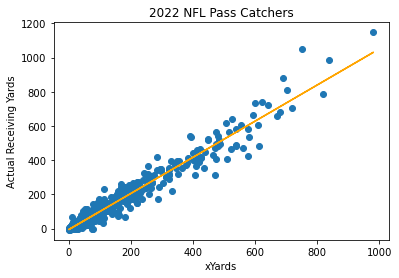

In [31]:
x = receivers['xYards']
y=receivers['yards_gained']
a, b = np.polyfit(x,y, 1)


plt.scatter(x,y)
plt.plot(x, a*x+b,color='orange')

plt.xlabel("xYards")
plt.ylabel("Actual Receiving Yards")
plt.title("2022 NFL Pass Catchers")


plt.show()

In [36]:
receivers['yards/game'] = receivers['yards_gained']/receivers['games'].round(1)
receivers['xYards/game'] = receivers['xYards']/receivers['games'].round(1)

receivers.sort_values('xYards',ascending=False).head(10)[['games','targets','yards/game','xYards/game','yards_gained','xYards','Diff']].round(1)

,,games,targets,yards/game,xYards/game,yards_gained,xYards,Diff
receiver_player_name,posteam,,,,,,,
T.Hill,MIA,10,106,114.8,98.1,1148.0,980.6,167.4
S.Diggs,BUF,9,99,109.4,93.1,985.0,838.3,146.7
D.Adams,LV,9,99,87.1,90.9,784.0,818.3,-34.3
J.Jefferson,MIN,9,99,116.6,83.5,1049.0,751.6,297.4
C.Lamb,DAL,9,88,78.4,80.1,706.0,720.5,-14.5
C.Kupp,LA,9,98,90.2,78.1,812.0,703.0,109.0
J.Waddle,MIA,10,75,87.8,69.0,878.0,690.3,187.7
M.Evans,TB,9,76,75.7,75.6,681.0,680.7,0.3
C.Olave,NO,9,77,73.1,74.4,658.0,669.7,-11.7


In [37]:
receivers.sort_values('Diff',ascending=False).head(10)[['games','targets','yards/game','xYards/game','yards_gained','xYards','Diff']].round(1)

,,games,targets,yards/game,xYards/game,yards_gained,xYards,Diff
receiver_player_name,posteam,,,,,,,
J.Jefferson,MIN,9,99,116.6,83.5,1049.0,751.6,297.4
J.Waddle,MIA,10,75,87.8,69.0,878.0,690.3,187.7
T.Hill,MIA,10,106,114.8,98.1,1148.0,980.6,167.4
D.Goedert,PHI,9,53,60.4,43.4,544.0,390.4,153.6
S.Diggs,BUF,9,99,109.4,93.1,985.0,838.3,146.7
T.Boyd,CIN,9,49,59.7,43.8,537.0,394.4,142.6
T.McLaurin,WAS,10,73,73.7,60.1,737.0,601.2,135.8
D.Njoku,CLE,7,42,59.7,40.7,418.0,285.2,132.8
T.Kelce,KC,9,84,82.2,69.1,740.0,621.7,118.3


In [38]:
receivers.sort_values('Diff',ascending=True).head(10)[['games','targets','yards/game','xYards/game','yards_gained','xYards','Diff']].round(1)

,,games,targets,yards/game,xYards/game,yards_gained,xYards,Diff
receiver_player_name,posteam,,,,,,,
K.Pitts,ATL,9,54,34.8,52.4,313.0,471.7,-158.7
D.Johnson,PIT,9,81,47.2,64.1,425.0,576.8,-151.8
D.Moore,CAR,10,77,48.2,61.3,482.0,613.5,-131.5
S.Miller,TB,7,34,24.3,41.0,170.0,287.3,-117.3
A.Green,ARI,7,25,9.4,26.1,66.0,182.4,-116.4
K.Osborn,MIN,9,44,24.4,37.0,220.0,332.9,-112.9
Z.Ertz,ARI,10,69,40.6,50.9,406.0,508.7,-102.7
R.Doubs,GB,9,50,34.9,45.1,314.0,405.9,-91.9
C.Godwin,TB,8,73,58.9,69.9,471.0,559.6,-88.6


## 3. Predicting future performance

Now that we have a model for expected yardage for each play, we now should see how this predicts future performance, while also looking at other factors that predict future performance.

### 3. Year n to Year n+1

In [39]:
#load in ten years worth of data for NFL pass attempts

all_throws = []
n_szn = []
plus_1_szn = []

for YEAR in tqdm(range(2012,2022)):
    data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(YEAR) + '.csv.gz',
                   compression= 'gzip', low_memory= False)

    data = data.loc[data.season_type=='REG']
    data['season'] = YEAR
    data = data.loc[(data.play_type.isin(['no_play','pass','run'])) & (data.epa.isna()==False)]

    data = data[data['posteam_type'].isna()==False]

    data.loc[data['pass']==1, 'play_type'] = 'pass'
    data.loc[data.rush==1, 'play_type'] = 'run'

    data.reset_index(drop=True, inplace=True)

    data = data[data['two_point_attempt']==0]

    data['home_implied_total'] = abs(data['total_line']/2 + data['spread_line']/2)
    data['away_implied_total'] = abs(data['total_line']/2 - data['spread_line']/2)
    implied_list = []
    for num in data.index:
        home_number = data.loc[num]['home_implied_total']
        away_number = data.loc[num]['away_implied_total']
        has_ball = data.loc[num]['posteam_type']
        number = total_finder(has_ball,home_number,away_number)
        implied_list.append(number)

    data['implied_posteam_total'] = implied_list
    throws = data[data['air_yards'].isna()==False]
    df = throws[['receiver_player_name','posteam','game_id','complete_pass','air_yards','yardline_100','ydstogo','implied_posteam_total','yards_gained','pass_touchdown','down','pass_location','week','season','home_implied_total','away_implied_total','posteam_type','cp','xyac_mean_yardage','qb_hit','yards_after_catch']]
  
  #apply model to the season's stats

    current_szn_df = df.dropna(subset=['receiver_player_name'])

#Create column for throws to the middle (1 for throws to middle, 0 for throws elsewhere)                               
    current_szn_df['middle'] = (current_szn_df['pass_location']=='middle')*1 
    current_szn_df['goal_to_go'] = (current_szn_df['yardline_100']<=10)*1 


    current_szn_df = current_szn_df[['receiver_player_name','posteam','yards_gained','down','yardline_100','ydstogo','implied_posteam_total','air_yards','middle','qb_hit','complete_pass','yards_after_catch','cp','xyac_mean_yardage','goal_to_go']].set_index(['receiver_player_name','posteam'])
    current_x = current_szn_df.drop(['yards_gained','goal_to_go','complete_pass','yards_after_catch','cp','xyac_mean_yardage'],axis=1)
    current_szn_df['xYards']=play_by_play_model.predict(current_x)
    current_szn_df = current_szn_df.reset_index()

#create seperate DF for YAC, looking only at completed passes; then merge this back with main DF
    yac_df = current_szn_df[current_szn_df['complete_pass']==1]
    yac_df = yac_df.groupby(['receiver_player_name','posteam']).sum()
    yac_df['yac/rec'] = yac_df['yards_after_catch']/yac_df['complete_pass']
    yac_df['xyac/rec'] = yac_df['xyac_mean_yardage']/yac_df['complete_pass']
    yac_df =yac_df[['xyac/rec','yac/rec','yards_after_catch','xyac_mean_yardage']]

    receivers = current_szn_df.groupby(['receiver_player_name','posteam']).agg({'down':'count','air_yards':'mean','yards_gained':'sum','xYards':'sum','complete_pass':'sum','cp':'mean','qb_hit':'mean','yardline_100':'mean','goal_to_go':'mean'})
    receivers['catch_rate'] = receivers['complete_pass']/receivers['down']                                                                         




    receivers.rename(columns={'down':'targets'},inplace=True)



    receivers['Diff'] = receivers['yards_gained'] - receivers['xYards']
    receivers = receivers.merge(yac_df,right_index=True,left_index=True)


    receivers['Szn'] = YEAR
  
  
  
  
  
  
  
    n_szn.append(receivers)



    n_szn_df=pd.concat(n_szn)
    n_minus_one_df = pd.concat(n_szn)
    n_minus_one_df['Szn'] = n_minus_one_df['Szn'] + 1
    n_minus_one_df.set_index('Szn',append=True,inplace=True)
    n_szn_df.set_index('Szn',append=True,inplace=True)



  0%|                                                    | 0/10 [00:00<?, ?it/s]/var/folders/zn/tr1yn_557hg80_br96jh2jmc0000gn/T/ipykernel_12579/2209231861.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_szn_df['middle'] = (current_szn_df['pass_location']=='middle')*1
/var/folders/zn/tr1yn_557hg80_br96jh2jmc0000gn/T/ipykernel_12579/2209231861.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_szn_df['goal_to_go'] = (current_szn_df['yardline_100']<=10)*1
 10%|████▍                     

In [40]:
n_minus_one_df = n_minus_one_df[n_minus_one_df['targets']>=50]

n_szn_df = n_szn_df[n_szn_df['targets']>=50]

In [41]:
df = n_minus_one_df.merge(n_szn_df,left_index=True,right_index=True)

In [42]:


df['cpoe_x'] = df['catch_rate_x'] - df['cp_x']

df['cpoe_y'] = df['catch_rate_y'] - df['cp_y']

#df

In [43]:
season_n_list = []
for col in df.columns:
    if "_x" in col:
        season_n_list.append(col)
        
season_n_list.append('yards_gained_y')

In [44]:
df[season_n_list].corr().sort_values('yards_gained_y',ascending=False)[['yards_gained_y']].round(2)

,yards_gained_y
yards_gained_y,1.00
yards_gained_x,0.55
xYards_x,0.53
targets_x,0.47
complete_pass_x,0.43
air_yards_x,0.35
xyac_mean_yardage_x,0.24
cpoe_x,0.23
Diff_x,0.18
yards_after_catch_x,0.16


*Among previous season stats (denoted with the suffix '_x'), actual yardage gained and expected yardage gained have a similar correlation with next season yardage gained.*

**What explains the difference between xYards and actual yardage gained?**

In [45]:
df['xYards/target_x'] = df['xYards_x']/df['targets_x']
df['xYards/target_y'] = df['xYards_y']/df['targets_y']

df['Yards/target_x'] = df['yards_gained_x']/df['targets_x']
df['Yards/target_y'] = df['yards_gained_y']/df['targets_y']

df['yac_oe_x'] = df['yac/rec_x'] - df['xyac/rec_x']
df['yac_oe_y'] = df['yac/rec_y'] - df['xyac/rec_y']

In [46]:
df.corr().sort_values('Diff_y',ascending=False)[['Diff_y']]

,Diff_y
Diff_y,1.000000
Yards/target_y,0.712706
cpoe_y,0.618604
yards_after_catch_y,0.551820
yac_oe_y,0.530838
catch_rate_y,0.519284
yards_gained_y,0.444222
yac/rec_y,0.413409
xyac_mean_yardage_y,0.372428
complete_pass_y,0.338030


**Year-to-year stability of various metrics**

In [47]:
metric_list = ['yards_gained','xYards','xYards/target','Yards/target','yac_oe','qb_hit','Diff','complete_pass','catch_rate','targets','air_yards','cp','cpoe','xyac/rec','yac/rec']

In [48]:
corr_dict = {}


for metric in metric_list:
  x = metric + '_x'
  y = metric + '_y'
  r = round(df[x].corr(df[y]),2)
  corr_dict.update({metric:r})


In [49]:
pd.DataFrame([corr_dict]).transpose().sort_values(0,ascending=False).rename(columns={0:'r'})

,r
air_yards,0.91
cp,0.88
xyac/rec,0.85
xYards/target,0.84
yac/rec,0.69
catch_rate,0.62
xYards,0.60
yards_gained,0.55
targets,0.51
complete_pass,0.49


**There is more stability in expected yardage from one year to the next (r=0.60) than actual yardage (0.55).** The delta between the two metrics ("Diff") is not very stable from one year to the next (0.21).*

This makese sence, since air yards are among the most stable metric from one year to the next (r=0.91), and air yards are the most important element of expected yards and expected yards per target (air yards also are a big part of other metrics with high stability, such as completion probability (CP) and xYards after catch per reception).

Also, metrics like completion percentage above expectation* (CPOE) and yards-after-catch above expecation* (YAC_OE) that make up much of the in-season difference between xYards and actual yards are not as stable from one year to the next (between season n and season n+1, r=0.38 for yac_oe, .29 for CPOE).


*CPOE and YAC_OE derive from the nflverse's built-in expected completion and expected YAC models. Further reading: https://www.opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/*

**Other conclusions:**

-A receiver's ability to earn targets seems more consistent than their ability to turn targets into catches (the year-to-year correlation for targets is 0.51, while the year-to-year correlation for completion percentage over expectation is just 0.29).

-Air yards are considerably more stable than yardage after the catch (r=0.91 for air yards year-over-year, compared to a mark of 0.38 for yards after catch above expectation).

**-Therefore, measuring "opportunity" itself (namely, the number of targets and the expected value of these targets) seems more important to making predictions than actually measuring what a receiver does with this opportunity.**

### In-season predictions

In this section, I will break down the last 10 season into six-week segments and see how well data in these segments predicts the following week.

In [50]:
import warnings
warnings.filterwarnings('ignore')

import tqdm.notebook as tq


In [51]:
#correct a few formatting errors in the data

def last_name(full):
  if full == 'DanielThomas':
    return 'Thomas'
  elif full == 'JulioJones':
    return 'Jones'
  elif '.' not in full:
    print(full)
    return full
  else:
    return full.split(".",1)[1]

In [52]:
#fix team abbreviations for teams that have moved cities

def team_fixer(team):
    if team == 'SD':
        return 'LAC'
    elif team == 'OAK':
        return 'LV'
    elif team == 'STL':
        return 'LA'
    else:
        return team

In [53]:
def name_changer(player):
    if 'Jr.' in player:
        return player.split(' Jr.')[0]
        #return 'D.J. Davis'
    elif 'II' in player:
        return player.split(' II')[0]
    else:
        return player

In [60]:
#load in ten years worth of data for NFL pass attempts

szn_receivers=[]
target_list=[]
  
df_list = []
weekly_list = []
target_week = [7,8,9,10,11,12,13,14,15,16,17,18]
week_list1= []
target_weeks=[]


all_throws = []
n_szn = []
plus_1_szn = []

for YEAR in tqdm(range(2012,2022)):
    print(YEAR)
    data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(YEAR) + '.csv.gz',
                   compression= 'gzip', low_memory= False)

    data = data.loc[data.season_type=='REG']
    data['season'] = YEAR
    data = data.loc[(data.play_type.isin(['no_play','pass','run'])) & (data.epa.isna()==False)]

    data = data[data['posteam_type'].isna()==False]

    data.loc[data['pass']==1, 'play_type'] = 'pass'
    data.loc[data.rush==1, 'play_type'] = 'run'

    data.reset_index(drop=True, inplace=True)

    data = data[data['two_point_attempt']==0]

    data['home_implied_total'] = abs(data['total_line']/2 + data['spread_line']/2)
    data['away_implied_total'] = abs(data['total_line']/2 - data['spread_line']/2)
    implied_list = []
    for num in data.index:
        home_number = data.loc[num]['home_implied_total']
        away_number = data.loc[num]['away_implied_total']
        has_ball = data.loc[num]['posteam_type']
        number = total_finder(has_ball,home_number,away_number)
        implied_list.append(number)

    data['implied_posteam_total'] = implied_list
    throws = data[data['air_yards'].isna()==False]
    df = throws[['receiver_player_name','week','posteam','game_id','complete_pass','air_yards','yardline_100','ydstogo','implied_posteam_total','yards_gained','pass_touchdown','down','pass_location','season','home_implied_total','away_implied_total','posteam_type','cp','xyac_mean_yardage','qb_hit','yards_after_catch','receiver_player_id']]

    current_szn_df = df.dropna(subset=['receiver_player_name'])

    #Create column for throws to the middle (1 for throws to middle, 0 for throws elsewhere)                               
    current_szn_df['middle'] = (current_szn_df['pass_location']=='middle')*1 
    current_szn_df['goal_to_go'] = (current_szn_df['yardline_100']<=10)*1 

    current_szn_df = current_szn_df[['receiver_player_name','week','posteam','yards_gained','down','yardline_100','ydstogo','implied_posteam_total','air_yards','middle','qb_hit','complete_pass','yards_after_catch','cp','xyac_mean_yardage','goal_to_go','receiver_player_id']].set_index(['receiver_player_name','posteam'])
    current_szn_df['year'] = YEAR
  
    #apply model to the season's stats
    current_x = current_szn_df.drop(['yards_gained','year','week','goal_to_go','complete_pass','yards_after_catch','cp','xyac_mean_yardage','receiver_player_id'],axis=1)
    current_szn_df['xYards']=play_by_play_model.predict(current_x)
    current_szn_df = current_szn_df.reset_index()
  
    #create seperate DF for YAC, looking only at completed passes; then merge this back with main DF
    yac_df = current_szn_df[current_szn_df['complete_pass']==1]
    weekly_yac = yac_df.groupby(['receiver_player_name','posteam','week']).agg({'complete_pass':'sum','yards_after_catch':'sum','xyac_mean_yardage':'sum'})
    
    
    #create new DF for team pass attempts to calculate metrics such as target share (targets per team attempts)
    weekly_pass_offense=current_szn_df.groupby(['posteam','week']).agg({'week':'count','air_yards':'sum'})
    weekly_pass_offense.rename(columns={'week':'team_attempts','air_yards':'team_air_yards'},inplace=True)
    team_attempts=weekly_pass_offense.reset_index()[['posteam','week','team_attempts','team_air_yards']]
    weekly_rec_group = current_szn_df.groupby(['receiver_player_name','posteam','week']).agg({'week':'max','down':'count','complete_pass':'sum','yards_gained':'sum','air_yards':'sum','xYards':'sum','cp':'sum','implied_posteam_total':'max','goal_to_go':'sum','qb_hit':'sum','middle':'sum','goal_to_go':'sum','receiver_player_id':'max'})
    weekly_rec_group.rename(columns={'week':'week_#','down':'targets'},inplace=True)
    weekly_rec_group = weekly_rec_group.merge(weekly_yac[['yards_after_catch','xyac_mean_yardage']],right_index=True,left_index=True)
    
    
    feature_receivers = weekly_rec_group.reset_index()

    feature_receivers.reset_index().set_index(['receiver_player_id','posteam','week'])
    
    week_df1 = feature_receivers.copy()
    week_df = week_df1.copy()
    week_df = week_df.reset_index().set_index(['receiver_player_name','posteam'])
    feature_df = feature_receivers.copy()
    
    
    #load in snap count data; this is important because players who go entire games without a target will not show up in the data for that game
    snap_df = nfl.import_snap_counts([YEAR])
    snap_df['team'] = snap_df['team'].apply(lambda x: team_fixer(x))
    snap_df = snap_df[snap_df['game_type']=='REG']
    snap_df = snap_df[['pfr_player_id','player','offense_snaps','offense_pct','week','team','game_id','position']]
    snap_df['player_copy'] = snap_df['player']
    snap_df.rename(columns={'player_copy':'full_name'},inplace=True)
    snap_df['full_name'] = snap_df['full_name'].apply(lambda x: name_changer(x))
    
    
    snap_df['week#'] = snap_df['week']
    snap_df = snap_df[snap_df['offense_snaps']>0]

    #create a unique identifier for each player so the snap data dataframe can be merged with the main receiver dataframe
    snap_df['last_name'] = snap_df['full_name'].apply(lambda x: x.split(" ",1)[1])
    snap_df['identifier'] = (snap_df['full_name']).str[0]+"."+snap_df['last_name']+"_"+snap_df['team']+"_"+snap_df['week#'].astype(str)
    
    feature_df_snaps = feature_df.reset_index()
    feature_df_snaps.rename(columns={'posteam':'team'},inplace=True)
    feature_df_snaps['szn'] = YEAR
    
    feature_df_snaps = feature_df_snaps.set_index(['receiver_player_id','team','week'])        
    for player_id in tq.tqdm(feature_df_snaps.index):
        player = player_id[0:2]
        team = player[1]
        week_df = pd.DataFrame()
        
        week_df['week_#']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
        new_df = feature_df_snaps.loc[player].merge(week_df,how='right')
        new_df['target_week'] = new_df['week_#']+1
        new_df['szn'] = new_df['szn'].fillna(YEAR)
        new_df['receiver_player_name'] = new_df['receiver_player_name'].fillna(new_df['receiver_player_name'].mode()[0])
        new_df['posteam'] = team
        
        new_df['identifier'] = (new_df['receiver_player_name']).str[0]+"."+new_df['receiver_player_name']+"_"+new_df['posteam']+"_"+new_df['week_#'].astype(str)
        new_df['last'] = new_df['receiver_player_name'].apply(lambda x: last_name(x))
        new_df['identifier'] = (new_df['receiver_player_name']).str[0]+"."+new_df['last']+"_"+new_df['posteam']+"_"+new_df['week_#'].astype(str)
               
        new_df = new_df.merge(snap_df[['identifier','full_name','game_id','offense_snaps','offense_pct','position']], on='identifier')
            
        #team_attempts = team_attempts.reset_index()
        
        team_attempts.rename(columns={'week':'week_#'},inplace=True)

        new_df = new_df.merge(team_attempts,on=['posteam','week_#'])
        
        new_df.fillna(0,inplace=True)


        #new_df will be the dataframe from trailing week data; 
        #the trailing period will be at a minimum three weeks worth of games and a max of six weeks
        
        
        #a copy of this dataframe will be for the target weeks
        target_df = new_df.copy()


        #calculate six week-rolling averages for key metrics
        new_df['xYards/game'] = new_df['xYards'].rolling(6,min_periods=3).mean()
        new_df['xYards_median'] = new_df['xYards'].rolling(6,min_periods=3).median()

        new_df['xYards_sum'] = new_df['xYards'].rolling(6,min_periods=3).sum()
        new_df['games_played'] = new_df['game_id'].rolling(6,min_periods=1).count()
        new_df['Yards_sum'] = new_df['yards_gained'].rolling(6,min_periods=3).sum()
        new_df['Yards/game'] = new_df['yards_gained'].rolling(6,min_periods=3).mean()
        new_df['air_yards_rolling'] = new_df['air_yards'].rolling(6,min_periods=3).sum()
        new_df['team_attempts_rolling'] = new_df['team_air_yards'].rolling(6,min_periods=3).sum()
        new_df['team_air_yards_rolling'] = new_df['team_air_yards'].rolling(6,min_periods=3).sum()
        new_df['complete_pass_rolling'] = new_df['complete_pass'].rolling(6,min_periods=3).sum()
        new_df['cp_rolling'] = new_df['cp'].rolling(6,min_periods=3).sum()
        new_df['yac_rolling'] = new_df['yards_after_catch'].rolling(6,min_periods=3).sum()
        new_df['xyac_rolling'] = new_df['xyac_mean_yardage'].rolling(6,min_periods=3).sum()
        new_df['targets_sum'] = new_df['targets'].rolling(6,min_periods=3).sum()
        new_df['snaps_sum'] = new_df['offense_snaps'].rolling(6,min_periods=3).sum()


        new_df = new_df.sort_values('week_#')
        
        target_df1 = pd.DataFrame()
        target_df1['target_week']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

        new_df = new_df.merge(target_df1,how='right').sort_values('target_week')
        new_df = new_df.fillna(method='ffill')

        df_list.append(new_df)
        target_list.append(target_df)
        
trailing_weeks = pd.concat(df_list)   
target_weeks = pd.concat(target_list)   

target_weeks = target_weeks[target_weeks['week_#']>3]
target_weeks = target_weeks.dropna()
target_weeks = target_weeks.drop(columns={'target_week'})
target_weeks.rename(columns={'week_#':'target_week'},inplace=True)


target_weeks = target_weeks.drop_duplicates()
trailing_weeks = trailing_weeks.drop_duplicates()


trailing_weeks = trailing_weeks[['receiver_player_name','posteam','szn','position','target_week','snaps_sum','games_played','xYards_sum','xYards/game','xYards_median','Yards/game','air_yards_rolling','team_attempts_rolling','team_air_yards_rolling','complete_pass_rolling','cp_rolling','yac_rolling','xyac_rolling','targets_sum']]
target_weeks = target_weeks[['receiver_player_name','posteam','target_week','szn','yards_gained','offense_snaps','targets','complete_pass','xYards','cp','yards_after_catch','xyac_mean_yardage','air_yards']]


target_weeks = target_weeks[target_weeks['target_week']>3]
trailing_weeks.set_index(['receiver_player_name','posteam','target_week','szn'],inplace=True)
target_weeks.set_index(['receiver_player_name','posteam','target_week','szn'],inplace=True)





  0%|                                                    | 0/10 [00:00<?, ?it/s]

2012


  0%|          | 0/3589 [00:00<?, ?it/s]

 10%|████▎                                      | 1/10 [02:17<20:38, 137.64s/it]

2013


  0%|          | 0/3603 [00:00<?, ?it/s]

 20%|████████▌                                  | 2/10 [04:34<18:17, 137.15s/it]

2014


  0%|          | 0/3654 [00:00<?, ?it/s]

 30%|████████████▉                              | 3/10 [06:53<16:06, 138.10s/it]

2015


  0%|          | 0/3684 [00:00<?, ?it/s]

 40%|█████████████████▏                         | 4/10 [09:11<13:48, 138.15s/it]

2016


  0%|          | 0/3700 [00:00<?, ?it/s]

 50%|█████████████████████▌                     | 5/10 [11:30<11:31, 138.27s/it]

2017


  0%|          | 0/3697 [00:00<?, ?it/s]

 60%|█████████████████████████▊                 | 6/10 [13:47<09:11, 137.75s/it]

2018


  0%|          | 0/3693 [00:00<?, ?it/s]

 70%|██████████████████████████████             | 7/10 [16:04<06:53, 137.73s/it]

2019


  0%|          | 0/3681 [00:00<?, ?it/s]

 80%|██████████████████████████████████▍        | 8/10 [18:21<04:34, 137.40s/it]

2020


  0%|          | 0/3807 [00:00<?, ?it/s]

 90%|██████████████████████████████████████▋    | 9/10 [20:44<02:19, 139.11s/it]

2021


  0%|          | 0/3955 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 10/10 [23:14<00:00, 139.47s/it]


In [61]:
#merge trailing and target dataframes

merged = trailing_weeks.merge(target_weeks,right_index=True,left_index=True)

merged = merged.iloc[:,~merged.columns.duplicated()]


In [62]:
merged = merged.drop_duplicates()

#merged.columns



In [64]:
#create various features

merged['yac/rec_x'] = merged['yac_rolling']/merged['complete_pass_rolling']
merged['xyac/rec_x'] = merged['xyac_rolling']/merged['complete_pass_rolling']


merged['yac/rec_y'] = merged['yards_after_catch']/merged['complete_pass']
merged['xyac/rec_y'] = merged['xyac_mean_yardage']/merged['complete_pass']

merged['yacoe_x'] = merged['yac/rec_x'] - merged['xyac/rec_x']
merged['yacoe_y'] = merged['yac/rec_y'] - merged['xyac/rec_y']

merged['target_share_x'] = merged['targets_sum']/merged['team_attempts_rolling']

merged['aDOT_x'] = merged['air_yards_rolling']/merged['targets_sum']
merged['aDOT_y'] = merged['air_yards']/merged['targets']

merged['AY_share_x'] = merged['air_yards_rolling']/merged['team_air_yards_rolling']



merged['catch_rate_x'] = merged['complete_pass_rolling']/merged['targets_sum']
merged['catch_rate_y'] = merged['complete_pass']/merged['targets']

merged['catch_over_e_x'] = merged['complete_pass_rolling']-merged['cp_rolling']
merged['catch_over_e_y'] = merged['complete_pass']-merged['cp']

merged['cpoe_x'] = merged['catch_over_e_x']/merged['targets_sum']
merged['cpoe_y'] = merged['catch_over_e_y']/merged['targets']


merged['Yards/game_x'] = merged['Yards/game']
merged['Yards/game_y'] = merged['yards_gained']

merged['xYards/game_x'] = merged['xYards/game']
merged['xYards/game_y'] = merged['xYards']


merged['targets/game_x'] = merged['targets_sum']/merged['games_played']
merged['targets/game_y'] = merged['targets']

merged['Diff_x'] = merged['Yards/game_x']-merged['xYards/game_x']
merged['Diff_y'] = merged['Yards/game_y']-merged['xYards/game_y']

In [65]:
merged['xYards/target_x'] = merged['xYards_sum']/merged['targets_sum']
merged['xYards/target_y'] = merged['xYards']/merged['targets']


In [68]:
corr_dict = {}
metric_list = ['Yards/game_x','xYards/game_x','aDOT_x','yacoe_x','catch_rate_x','catch_rate_x','catch_over_e_x','targets/game_x','Diff_x']

for metric in metric_list:
 x = metric
 y = metric[:-2] + '_y'
 r = round(merged[x].corr(merged[y]),2)
 corr_dict.update({metric[:-2]:r})

In [69]:
pd.DataFrame([corr_dict]).transpose().sort_values(0,ascending=False).rename(columns={0:'r'})

,r
xYards/game,0.73
targets/game,0.71
Yards/game,0.62
aDOT,0.62
catch_rate,0.25
catch_over_e,0.07
yacoe,0.05
Diff,0.04


As was the case when looking at things from one year to the next, within the season, expected yards are more consistent than actual yardage.

Also, opportunity metrics (aDOT and target volume) are more consistent than efficiency metrics (catch rate and yards after catch stats). This is also evident in the low correlation between the delta between yards and xYards from the trailing-week group and target-week group.



In [72]:
merged[['Yards/game_x','xYards/game_x','aDOT_x','yacoe_x','target_share_x','xYards/target_x','catch_rate_x','Diff_x','catch_over_e_x','targets/game_x','yards_gained']].corr()[['yards_gained']].sort_values('yards_gained',ascending=False)

,yards_gained
yards_gained,1.000000
xYards/game_x,0.626052
Yards/game_x,0.617369
targets/game_x,0.613934
target_share_x,0.598281
aDOT_x,0.301779
xYards/target_x,0.287211
catch_over_e_x,0.123823
Diff_x,0.087853
yacoe_x,-0.001469


Within the season, 3-6 games worth of expected yardage is more predictive of yardage the following game than trailing actual yardage in the trailing span.

In [73]:
merged_model = merged.dropna()

Before applying these findings to a model, we should first look at the difference between different positions.

In [74]:
def position_handler(pos):
  if pos in ['WR','RB','TE']:
    return pos
  elif 'FB' in pos:
    return 'FB'
  elif pos == 'RB/W':
    return 'RB'
  elif pos == 'WR/R':
    return 'WR'
  elif pos == 'HB':
    return 'RB'
  else:
    return 'other'

In [75]:
merged_model['position'] = merged_model['position'].apply(lambda x: position_handler(x))

In [76]:
for pos in merged_model['position'].unique():
  positional_model = merged_model[merged_model['position']==pos]
  yards_per_game = round(positional_model['yards_gained'].mean(),1)
  print('{}: {}'.format(pos, yards_per_game))



RB: 21.4
FB: 13.8
TE: 31.4
WR: 46.9
other: 18.3


Wide receivers gain much more yardage on average than other positions, so the model should account for this.

Also, since non-WR/TE/RB/FB targets are rare, we should drop them to ensure the model is more generizable.

In [77]:
#one hot-encode position

one_hot = pd.get_dummies(merged_model['position'])
merged_model = merged_model.drop('position',axis = 1)

merged_model = merged_model.join(one_hot)

#drop non WR/TE/RB/FB
merged_model = merged_model[merged_model['other']==0]

In [90]:
X = merged_model[['xYards/game','RB','WR','FB']].dropna()
#X = merged_model[['xYards/game','Yards/game','RB','WR','FB']].dropna()


y = merged_model['yards_gained']
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
in_season_model = GradientBoostingRegressor(max_depth=1,min_samples_split=2, n_estimators=100).fit(X_train, y_train)

#print('xYards per game w/ positions:',in_season_model.score(X_test, y_test).round(3))
print('xYards mean:',in_season_model.score(X_test, y_test).round(3))

xYards mean: 0.287


In [79]:
print('r^2:',in_season_model.score(X_test, y_test).round(3))


feature_df = pd.DataFrame(in_season_model.feature_importances_)
feature_list = []

for feature in X.columns:
    feature_list.append(feature)

feature_df['Feature'] = feature_list
feature_df.rename(columns = {0:'Importance'},inplace=True)

feature_df = feature_df[['Feature','Importance']].sort_values('Importance',ascending = False)

feature_df.sort_values('Importance',ascending=False).round(3)

r^2: 0.287


,Feature,Importance
0,xYards/game,0.937
2,WR,0.051
1,RB,0.009
3,FB,0.002


The r-squared for our predicted yards and actual yardage in the test set is .287. How does this compare to how well 

In [80]:
X = merged_model[['xYards/game','Yards/game']].dropna()


y = merged_model['yards_gained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)



In [81]:
X_test['yards_gained'] = y_test

X_test.corr()

,xYards/game,Yards/game,yards_gained
xYards/game,1.000000,0.935188,0.531765
Yards/game,0.935188,1.000000,0.526975
yards_gained,0.531765,0.526975,1.000000


In [82]:
model = 0.287
xYards_only = 0.531765
Yards_only = 0.526975

print('Test set\n')
print('Model: {}'.format(model))
print('xYards/game: {}'.format(round(xYards_only*xYards_only,3)))
print('Yards/game: {}'.format(round(Yards_only*Yards_only,3)))

Test set

Model: 0.287
xYards/game: 0.283
Yards/game: 0.278


In [87]:
#save model for future use

import joblib
joblib.dump(in_season_model, 'model.pkl') 


['model.pkl']

# Conclusions

**The model does a better job of predicting future yardage than xYards per game alone, as well as yards per game.**

The model is based primarily on volume and opportunity; since the model itself is more predictive of future production than past production, this suggests the ability to get open (i.e. earn targets) and do so in advantageous positions is a more reliable means to success than outperforming expectation.

We have further evidence for this by observing how target volume and air yards are more stable and predictive of future production than efficiency metrics like catch rate over expectation and YAC per reception.

This is not to say such metrics are not the product of an actual skill, but rather there is more noise than signal here, especially in the short term (there is less consistency in CPOE and YAC_OE within a season than from season-to-season).
